In [1]:
if __name__=="__main__":
	import sys
	sys.path.append('/Users/baljyot/Documents/CODE/GitHub_t2/Baljyot_EXP_RPOC/Scripts')

import numpy as np
import os
import scipy.stats as stats
import matplotlib.pyplot as plt
import tifffile as tiff
from src.SMT_Analysis_BP.helpers.Analysis_functions import *
from src.SMT_Analysis_BP.helpers.blob_detection import *
from skimage import io
#import curve_fit 
from scipy.optimize import curve_fit
import src.SMT_Analysis_BP.helpers.fbm_utility as fbm_utility
import src.SMT_Analysis_BP.helpers.simulate_foci as simulate_foci
import src.SMT_Analysis_BP.helpers.simulate_cells as simulate_cells
import src.SMT_Analysis_BP.helpers.SMT_converters as smt
import src.SMT_Analysis_BP.helpers.smallestenclosingcircle as smallestenclosingcircle
#import convexhull
from scipy.spatial import ConvexHull
from sklearn.cluster import DBSCAN


In [2]:
#remove warnings
import warnings
warnings.filterwarnings('ignore')


In [3]:
#lets make a utility function to perform the scale-space
def scale_utility(img_map,threshold):
    b = blob_detection(path = img_map,\
                    median= False,\
                    threshold= threshold, \
                    min_sigma= 1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 500, \
                    overlap = 0.5, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":5,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    return c

#utility function to create the parameter dics

def utility_params(initial_dict,num_tracks,mean_track_length,density_dif,track_distribution,psf):
    initial_dict = initial_dict
    cell_parms = {
        "diffusion_coefficients":np.array(list(0.45*np.ones(num_tracks))),
        "initials": initial_dict,
        "num_tracks":num_tracks,
        "track_type":"fbm",
        "hursts":np.array(list(0.2*np.ones(num_tracks))),
        "dims":(200,200),
        "movie_frames":500,
        "cell_space":np.array([80,120,90,105])
    }     
    global_sim_params = {
        "track_length_mean":mean_track_length,
        "track_distribution":track_distribution,
        "exposure_time":20,#ms same as frame_time
        "base_noise":140,
        "point_intensity":20,
        "psf_sigma":psf,
        "frame_time":20,#ms
        "pixel_size":130,
        "axial_function":"exponential",
        "density_dif": density_dif
    }
    return initial_dict,cell_parms,global_sim_params

#define a utility function to detect the true positives and the error in the centers and scale
def true_positive_and_erros(true_clusters,found_clusters,center_threshold=0.5):
    '''true clusters is the initial_dict, the found is the scale space output from the blob detection'''
    #get the true centers and scale
    true_centers = true_clusters["initial_centers"]
    true_scale = true_clusters["initial_scale"]
    #get the found centers and scale
    found_centers = np.array([found_clusters["Fitted"][i][:2] for i in range(len(found_clusters["Fitted"]))])

    found_scale = np.array([np.mean([found_clusters["Fitted"][i][2],found_clusters["Fitted"][i][3]]) for i in range(len(found_clusters["Fitted"]))])
    #get the true positives
    true_center_TP_center_error = np.ones(len(true_centers))*np.nan
    true_center_TP_scale_error = np.ones(len(true_centers))*np.nan
    for i in range(len(true_centers)):
        for j in range(len(found_centers)):
            if np.linalg.norm(true_centers[i]-found_centers[j][::-1])<center_threshold:
                if true_center_TP_center_error[i] > np.linalg.norm(true_centers[i]-found_centers[j][::-1]) or np.isnan(true_center_TP_center_error[i]):
                    true_center_TP_center_error[i] = np.linalg.norm(true_centers[i]-found_centers[j][::-1])
                    true_center_TP_scale_error[i] = np.abs(true_scale[i]-found_scale[j])/true_scale[i]

    #get the false positives
    #this is just the total number of found centers minus the true positives (len of the true_center_TP_center_error without the nans)
    false_positives = len(found_centers)-len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
    #get the true positives
    true_positive_num = len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])

    
    return true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error

#lets make a utility function to create all points in the cell using the points per frame dict
def create_all_points(points_per_frame_dict):
    all_points = []
    for frame in points_per_frame_dict.keys():
        #only take the x,y coordinates
        if len(points_per_frame_dict[frame])>0:
            all_points.extend(np.array(points_per_frame_dict[frame])[:,0:2])
    return np.array(all_points)

#lets make a utility function to perform DBSCAN on the points per frame dict using supplied parameters D and minPts.
def perform_DBSCAN(points_per_frame_dict,D,minPts,convert=False):
    if convert == True:
        all_points = create_all_points(points_per_frame_dict)
    else:
        all_points = points_per_frame_dict
    db = DBSCAN(eps=D, min_samples=minPts).fit(all_points)
    labels = db.labels_
    return labels

#make a utility function for DBSCAN TP and FP and center and scale errors
def DBSCAN_TP_FP_center_scale_error(ID_dict,points_per_frame,D,minPts,convert=False,threshold=1.):
    #convert the points_perf_frame dict to a list of points
    if convert == True:
        all_points = create_all_points(points_per_frame)
    else:
        all_points = points_per_frame
    #perform DBSCAN
    labels = perform_DBSCAN(all_points,D,minPts,convert=False)
    #number of clusters
    num_clusters = len(np.unique(labels))-1

    cluster_scales = []
    cluster_centers = []
    for cluster in np.unique(labels):
        if cluster != -1:
            circle_made = smallestenclosingcircle.make_circle(points_per_frame[labels==cluster])
            cluster_scales.append(circle_made[2])
            cluster_centers.append(circle_made[0:2])
    cluster_scales = np.array(cluster_scales)
    cluster_centers = np.array(cluster_centers)
    #lets get the true positives and errors
    #find the true centers and scales
    true_centers = np.array(ID_dict["initial_centers"])
    true_scale = np.array(ID_dict["initial_scale"])
    true_center_TP_center_error = np.ones(len(true_centers))*np.nan
    true_center_TP_scale_error = np.ones(len(true_centers))*np.nan

    if num_clusters > 0:
        for l in range(len(true_centers)):
            for m in range(len(cluster_centers)):
                if np.linalg.norm(true_centers[l]-cluster_centers[m])<threshold:
                    if true_center_TP_center_error[l] > np.linalg.norm(true_centers[l]-cluster_centers[m]) or np.isnan(true_center_TP_center_error[l]):
                        true_center_TP_center_error[l] = np.linalg.norm(true_centers[l]-cluster_centers[m])
                        true_center_TP_scale_error[l] = np.abs(true_scale[l]-cluster_scales[m])/true_scale[l]
    false_positives = len(cluster_centers)-len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
    #get the true positives
    true_positive_num = len(true_center_TP_center_error[~np.isnan(true_center_TP_center_error)])
    return true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error
    


In [ ]:
#lets set up a range of condensates to simulate
ID_same_size_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([2]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
ID_same_size_2 = {
    "initial_centers":np.array([[100,100],[90,95]]),
    "initial_scale": np.array([2,2]),
    "diffusion_coefficient": np.array([0,0]),
    "hurst_exponent": np.array([0.2,0.2])
}
ID_same_size_3 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100]]),
    "initial_scale": np.array([2,2,2]),
    "diffusion_coefficient": np.array([0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2])
}
ID_same_size_4 = {
    "initial_centers":np.array([[100,100],[90,95],[110,100],[115,95]]),
    "initial_scale": np.array([2,2,2,2]),
    "diffusion_coefficient": np.array([0,0,0,0]),
    "hurst_exponent": np.array([0.2,0.2,0.2,0.2])
}

initial_dict_collection_same_size = [ID_same_size_1,ID_same_size_2,ID_same_size_3,ID_same_size_4]




#sim one blob 
ID_same_size_1_sim, cell_parms_1_sim, global_sim_params_1_sim = utility_params(ID_same_size_1,1000,1,5,"constant",1.)
cell_sim_1_sim = simulate_cells.Simulate_cells(cell_parms_1_sim,global_sim_params_1_sim)
a_1_sim = cell_sim_1_sim.get_cell()

#sim two blobs
ID_same_size_2_sim, cell_parms_2_sim, global_sim_params_2_sim = utility_params(ID_same_size_2,1000,1,5,"constant",1.)
cell_sim_2_sim = simulate_cells.Simulate_cells(cell_parms_2_sim,global_sim_params_2_sim)
a_2_sim = cell_sim_2_sim.get_cell()

#sim three blobs
ID_same_size_3_sim, cell_parms_3_sim, global_sim_params_3_sim = utility_params(ID_same_size_3,1000,1,5,"constant",1.)
cell_sim_3_sim = simulate_cells.Simulate_cells(cell_parms_3_sim,global_sim_params_3_sim)
a_3_sim = cell_sim_3_sim.get_cell()

#sim four blobs
ID_same_size_4_sim, cell_parms_4_sim, global_sim_params_4_sim = utility_params(ID_same_size_4,1000,1,5,"constant",1.)
cell_sim_4_sim = simulate_cells.Simulate_cells(cell_parms_4_sim,global_sim_params_4_sim)
a_4_sim = cell_sim_4_sim.get_cell()

#lets perform scale selection on the simulated data
c_1_sim = scale_utility(img_map = np.sum(a_1_sim["map"],axis=0),threshold = 1.1e3)
c_2_sim = scale_utility(img_map = np.sum(a_2_sim["map"],axis=0),threshold = 1.1e3)
c_3_sim = scale_utility(img_map = np.sum(a_3_sim["map"],axis=0),threshold = 1.1e3)
c_4_sim = scale_utility(img_map = np.sum(a_4_sim["map"],axis=0),threshold = 1.1e3)



In [ ]:
#plot the cell
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(1, 4)


ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(np.sum(a_1_sim["map"],axis=0),cmap="gray")
#plot the blob detection
for j in range(len(c_1_sim["Fitted"])):
    circle = plt.Circle((c_1_sim["Fitted"][j][1],c_1_sim["Fitted"][j][0]), np.mean([c_1_sim["Fitted"][j][3],c_1_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax1.add_artist(circle)
#plot the true foci
for j in range(len(ID_same_size_1_sim["initial_centers"])):
    circle = plt.Circle((ID_same_size_1_sim["initial_centers"][j][0],ID_same_size_1_sim["initial_centers"][j][1]), ID_same_size_1_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax1.add_artist(circle)

ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(np.sum(a_2_sim["map"],axis=0),cmap="gray")
#plot the blob detection
for j in range(len(c_2_sim["Fitted"])):
    circle = plt.Circle((c_2_sim["Fitted"][j][1],c_2_sim["Fitted"][j][0]), np.mean([c_2_sim["Fitted"][j][3],c_2_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax2.add_artist(circle)
#plot the true foci
for j in range(len(ID_same_size_2_sim["initial_centers"])):
    circle = plt.Circle((ID_same_size_2_sim["initial_centers"][j][0],ID_same_size_2_sim["initial_centers"][j][1]), ID_same_size_2_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax2.add_artist(circle)


ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(np.sum(a_3_sim["map"],axis=0),cmap="gray")
#plot the blob detection
for j in range(len(c_3_sim["Fitted"])):
    circle = plt.Circle((c_3_sim["Fitted"][j][1],c_3_sim["Fitted"][j][0]), np.mean([c_3_sim["Fitted"][j][3],c_3_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax3.add_artist(circle)
#plot the true foci
for j in range(len(ID_same_size_3_sim["initial_centers"])):
    circle = plt.Circle((ID_same_size_3_sim["initial_centers"][j][0],ID_same_size_3_sim["initial_centers"][j][1]), ID_same_size_3_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax3.add_artist(circle)

ax4 = fig.add_subplot(gs[0, 3])
ax4.imshow(np.sum(a_4_sim["map"],axis=0),cmap="gray")
#plot the blob detection
for j in range(len(c_4_sim["Fitted"])):
    circle = plt.Circle((c_4_sim["Fitted"][j][1],c_4_sim["Fitted"][j][0]), np.mean([c_4_sim["Fitted"][j][3],c_4_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax4.add_artist(circle)
#plot the true foci
for j in range(len(ID_same_size_4_sim["initial_centers"])):
    circle = plt.Circle((ID_same_size_4_sim["initial_centers"][j][0],ID_same_size_4_sim["initial_centers"][j][1]), ID_same_size_4_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax4.add_artist(circle)




#restrict the axis to the cell space
#restrict the axis to the cell space +- 2 pixels
ax1.set_xlim(cell_parms_1_sim["cell_space"][0]-2,cell_parms_1_sim["cell_space"][1]+2)
ax1.set_ylim(cell_parms_1_sim["cell_space"][2]-2,cell_parms_1_sim["cell_space"][3]+2)
ax2.set_xlim(cell_parms_2_sim["cell_space"][0]-2,cell_parms_2_sim["cell_space"][1]+2)
ax2.set_ylim(cell_parms_2_sim["cell_space"][2]-2,cell_parms_2_sim["cell_space"][3]+2)
ax3.set_xlim(cell_parms_3_sim["cell_space"][0]-2,cell_parms_3_sim["cell_space"][1]+2)
ax3.set_ylim(cell_parms_3_sim["cell_space"][2]-2,cell_parms_3_sim["cell_space"][3]+2)
ax4.set_xlim(cell_parms_4_sim["cell_space"][0]-2,cell_parms_4_sim["cell_space"][1]+2)
ax4.set_ylim(cell_parms_4_sim["cell_space"][2]-2,cell_parms_4_sim["cell_space"][3]+2)

#add the rectangle
rect1 = plt.Rectangle((cell_parms_1_sim["cell_space"][0],cell_parms_1_sim["cell_space"][2]), cell_parms_1_sim["cell_space"][1]-cell_parms_1_sim["cell_space"][0], cell_parms_1_sim["cell_space"][3]-cell_parms_1_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax1.add_artist(rect1)
rect2 = plt.Rectangle((cell_parms_2_sim["cell_space"][0],cell_parms_2_sim["cell_space"][2]), cell_parms_2_sim["cell_space"][1]-cell_parms_2_sim["cell_space"][0], cell_parms_2_sim["cell_space"][3]-cell_parms_2_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax2.add_artist(rect2)
rect3 = plt.Rectangle((cell_parms_3_sim["cell_space"][0],cell_parms_3_sim["cell_space"][2]), cell_parms_3_sim["cell_space"][1]-cell_parms_3_sim["cell_space"][0], cell_parms_3_sim["cell_space"][3]-cell_parms_3_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax3.add_artist(rect3)
rect4 = plt.Rectangle((cell_parms_4_sim["cell_space"][0],cell_parms_4_sim["cell_space"][2]), cell_parms_4_sim["cell_space"][1]-cell_parms_4_sim["cell_space"][0], cell_parms_4_sim["cell_space"][3]-cell_parms_4_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax4.add_artist(rect4)

#remove the ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])
ax4.set_xticks([])
ax4.set_yticks([])
#for the ylabel on the first plot write Sample Simulations
ax1.set_ylabel("Same Size",fontsize=20)
#make the title for each plot
ax1.set_title("1 Focus",fontsize=20)
ax2.set_title("2 Foci",fontsize=20)
ax3.set_title("3 Foci",fontsize=20)
ax4.set_title("4 Foci",fontsize=20)
plt.tight_layout()
SAVE = False
if SAVE == True:
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/4_Foci.svg",format="svg",dpi=200)
plt.show()

In [ ]:
#load some data from with open('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/num_4_file_data.pkl', 'wb') as f:
import pickle
with open('/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/num_4_file_data.pkl', 'rb') as f:
    num_4_file_data = pickle.load(f)

TP_collection_ID_same_size_4,FP_collection_ID_same_size_4,center_error_collection_ID_same_size_4,scale_error_collection_ID_same_size_4,map_collection_ID_same_size_4 = num_4_file_data

with open('/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/num_1_file_data.pkl', 'rb') as f:
    num_1_file_data = pickle.load(f)

TP_collection_ID_same_size_1,FP_collection_ID_same_size_1,center_error_collection_ID_same_size_1,scale_error_collection_ID_same_size_1,map_collection_ID_same_size_1 = num_1_file_data

with open('/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/num_2_file_data.pkl', 'rb') as f:
    num_2_file_data = pickle.load(f)

TP_collection_ID_same_size_2,FP_collection_ID_same_size_2,center_error_collection_ID_same_size_2,scale_error_collection_ID_same_size_2,map_collection_ID_same_size_2 = num_2_file_data

with open('/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/num_3_file_data.pkl', 'rb') as f:
    num_3_file_data = pickle.load(f)

TP_collection_ID_same_size_3,FP_collection_ID_same_size_3,center_error_collection_ID_same_size_3,scale_error_collection_ID_same_size_3,map_collection_ID_same_size_3 = num_3_file_data



In [ ]:
#lets make a figure where we plot the map for 3 different track lengths (0,2,4) index 
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(1, 3)
#perform scale selection on the simulated data
c_1_sim = scale_utility(map_collection_ID_same_size_4[0,0,:,:],threshold = 1.1e3)
c_2_sim = scale_utility(map_collection_ID_same_size_4[2,0,:,:],threshold = 1.1e3)
c_3_sim = scale_utility(map_collection_ID_same_size_4[4,0,:,:],threshold = 1.1e3)

ax1 = fig.add_subplot(gs[0, 0])
ax1.imshow(map_collection_ID_same_size_4[0,0,:,:],cmap="gray")
ax1.set_title("{0} Localizations per Frame ".format(300/4/500) + r"$\frac{1}{\mu m^{2}}$",fontsize=20)
ax2 = fig.add_subplot(gs[0, 1])
ax2.imshow(map_collection_ID_same_size_4[2,0,:,:],cmap="gray")
ax2.set_title("{0} Localizations per Frame ".format(900/4/500)+ r"$\frac{1}{\mu m^{2}}$",fontsize=20)
ax3 = fig.add_subplot(gs[0, 2])
ax3.imshow(map_collection_ID_same_size_4[4,0,:,:],cmap="gray")
ax3.set_title("{0} Localizations per Frame ".format(1500/4/500)+ r"$\frac{1}{\mu m^{2}}$",fontsize=20)

#lets plot the rectangle
rect1 = plt.Rectangle((cell_parms_1_sim["cell_space"][0],cell_parms_1_sim["cell_space"][2]), cell_parms_1_sim["cell_space"][1]-cell_parms_1_sim["cell_space"][0], cell_parms_1_sim["cell_space"][3]-cell_parms_1_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax1.add_artist(rect1)
rect2 = plt.Rectangle((cell_parms_1_sim["cell_space"][0],cell_parms_1_sim["cell_space"][2]), cell_parms_1_sim["cell_space"][1]-cell_parms_1_sim["cell_space"][0], cell_parms_1_sim["cell_space"][3]-cell_parms_1_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax2.add_artist(rect2)
rect3 = plt.Rectangle((cell_parms_1_sim["cell_space"][0],cell_parms_1_sim["cell_space"][2]), cell_parms_1_sim["cell_space"][1]-cell_parms_1_sim["cell_space"][0], cell_parms_1_sim["cell_space"][3]-cell_parms_1_sim["cell_space"][2], color='w', fill=False,linestyle='--')
ax3.add_artist(rect3)

#plot the true foci
for j in range(len(ID_same_size_4_sim["initial_centers"])):
    circle1 = plt.Circle((ID_same_size_4_sim["initial_centers"][j][0],ID_same_size_4_sim["initial_centers"][j][1]), ID_same_size_4_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    circle2 = plt.Circle((ID_same_size_4_sim["initial_centers"][j][0],ID_same_size_4_sim["initial_centers"][j][1]), ID_same_size_4_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    circle3 = plt.Circle((ID_same_size_4_sim["initial_centers"][j][0],ID_same_size_4_sim["initial_centers"][j][1]), ID_same_size_4_sim["initial_scale"][j], color='r', fill=False, linestyle='-',linewidth=1)
    ax1.add_artist(circle1)
    ax2.add_artist(circle2)
    ax3.add_artist(circle3)

#add the scale space
for j in range(len(c_1_sim["Fitted"])):
    circle = plt.Circle((c_1_sim["Fitted"][j][1],c_1_sim["Fitted"][j][0]), np.mean([c_1_sim["Fitted"][j][3],c_1_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax1.add_artist(circle)
for j in range(len(c_2_sim["Fitted"])):
    circle = plt.Circle((c_2_sim["Fitted"][j][1],c_2_sim["Fitted"][j][0]), np.mean([c_2_sim["Fitted"][j][3],c_2_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax2.add_artist(circle)
for j in range(len(c_3_sim["Fitted"])):
    circle = plt.Circle((c_3_sim["Fitted"][j][1],c_3_sim["Fitted"][j][0]), np.mean([c_3_sim["Fitted"][j][3],c_3_sim["Fitted"][j][2]]), color='b', fill=False, linestyle='--',linewidth=1)
    ax3.add_artist(circle)


#remove the ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])
ax3.set_xticks([])
ax3.set_yticks([])

#restrict the axis to the cell space +- 2 pixels
ax1.set_xlim(cell_parms_1_sim["cell_space"][0]-2,cell_parms_1_sim["cell_space"][1]+2)
ax1.set_ylim(cell_parms_1_sim["cell_space"][2]-2,cell_parms_1_sim["cell_space"][3]+2)
ax2.set_xlim(cell_parms_1_sim["cell_space"][0]-2,cell_parms_1_sim["cell_space"][1]+2)
ax2.set_ylim(cell_parms_1_sim["cell_space"][2]-2,cell_parms_1_sim["cell_space"][3]+2)
ax3.set_xlim(cell_parms_1_sim["cell_space"][0]-2,cell_parms_1_sim["cell_space"][1]+2)
ax3.set_ylim(cell_parms_1_sim["cell_space"][2]-2,cell_parms_1_sim["cell_space"][3]+2)

plt.tight_layout()
SAVE = False
if SAVE == True:
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/Same_Size_300_900_1500.svg",format="svg",dpi=200)
    
plt.show()

In [ ]:
#okay lets just plot the TP,c error, s error for each localization number for each of the 4 foci on a single plot with x being the 1-4 foci
fig = plt.figure(figsize=(10,5))
gs = fig.add_gridspec(1, 3)
ax1 = fig.add_subplot(gs[0, 0])
track_lengths = np.array([300,600,900,1200,1500,1800,2100])/4/500
repeats = 1
threshold = 1.1e3
#the first one is the TP for each number of localizations (x axis is the number of localizations)
# ax1.plot(track_lengths,np.mean(TP_collection_ID_same_size_1,axis=1)/1.,color="r",label="1 Foci",marker="o",alpha = 0.5)
# ax1.plot(track_lengths,np.mean(TP_collection_ID_same_size_2,axis=1)/2.,color="b",label="2 Foci",marker="o",alpha = 0.5)
# ax1.plot(track_lengths,np.mean(TP_collection_ID_same_size_3,axis=1)/3.,color="g",label="3 Foci",marker="o",alpha = 0.5)
# ax1.plot(track_lengths,np.mean(TP_collection_ID_same_size_4,axis=1)/4.,color="k",label="4 Foci",marker="o",alpha = 0.5)
ax1.errorbar(track_lengths,np.mean(TP_collection_ID_same_size_1,axis=1)/1.,yerr=np.std(TP_collection_ID_same_size_1,axis=1)/1.,color="r",label="1 Foci",marker="o")
ax1.errorbar(track_lengths,np.mean(TP_collection_ID_same_size_2,axis=1)/2.,yerr=np.std(TP_collection_ID_same_size_2,axis=1)/2.,color="b",label="2 Foci",marker="o")
ax1.errorbar(track_lengths,np.mean(TP_collection_ID_same_size_3,axis=1)/3.,yerr=np.std(TP_collection_ID_same_size_3,axis=1)/3.,color="g",label="3 Foci",marker="o")
ax1.errorbar(track_lengths,np.mean(TP_collection_ID_same_size_4,axis=1)/4.,yerr=np.std(TP_collection_ID_same_size_4,axis=1)/4.,color="k",label="4 Foci",marker="o")
ax1.set_xlabel("Localizations per Frame " + r"$\frac{1}{\mu m^{2}}$",fontsize=10)
ax1.set_ylabel("True Positive Rate",fontsize=10)
ax1.set_title("True Positive Rate",fontsize=10)
ax1.legend(fontsize=10)

#for the second one do the scale error
ax2 = fig.add_subplot(gs[0, 1])
ax2.errorbar(track_lengths,np.mean(np.mean(scale_error_collection_ID_same_size_1,axis=1),axis=1),yerr=np.std(np.mean(scale_error_collection_ID_same_size_1,axis=1),axis=1),color="r",label="1 Foci",marker="o")
ax2.errorbar(track_lengths,np.mean(np.mean(scale_error_collection_ID_same_size_2,axis=1),axis=1),yerr=np.std(np.mean(scale_error_collection_ID_same_size_2,axis=1),axis=1),color="b",label="2 Foci",marker="o")
ax2.errorbar(track_lengths,np.mean(np.mean(scale_error_collection_ID_same_size_3,axis=1),axis=1),yerr=np.std(np.mean(scale_error_collection_ID_same_size_3,axis=1),axis=1),color="g",label="3 Foci",marker="o")
ax2.errorbar(track_lengths,np.mean(np.mean(scale_error_collection_ID_same_size_4,axis=1),axis=1),yerr=np.std(np.mean(scale_error_collection_ID_same_size_4,axis=1),axis=1),color="k",label="4 Foci",marker="o")
ax2.set_xlabel("Localizations per Frame " + r"$\frac{1}{\mu m^{2}}$",fontsize=10)
ax2.set_ylabel("Percent Size Error",fontsize=10)
ax2.set_title("Percent Size Error",fontsize=10)
ax2.legend(fontsize=10)
ax2.set_ylim(0,1)

#for the third one do the center error
ax3 = fig.add_subplot(gs[0, 2])
ax3.errorbar(track_lengths,np.mean(np.mean(center_error_collection_ID_same_size_1,axis=1),axis=1)*130,yerr=np.std(np.mean(center_error_collection_ID_same_size_1,axis=1),axis=1)*130,color="r",label="1 Foci",marker="o")
ax3.errorbar(track_lengths,np.mean(np.mean(center_error_collection_ID_same_size_2,axis=1),axis=1)*130,yerr=np.std(np.mean(center_error_collection_ID_same_size_2,axis=1),axis=1)*130,color="b",label="2 Foci",marker="o")
ax3.errorbar(track_lengths,np.mean(np.mean(center_error_collection_ID_same_size_3,axis=1),axis=1)*130,yerr=np.std(np.mean(center_error_collection_ID_same_size_3,axis=1),axis=1)*130,color="g",label="3 Foci",marker="o")
ax3.errorbar(track_lengths,np.mean(np.mean(center_error_collection_ID_same_size_4,axis=1),axis=1)*130,yerr=np.std(np.mean(center_error_collection_ID_same_size_4,axis=1),axis=1)*130,color="k",label="4 Foci",marker="o")
ax3.set_xlabel("Localizations per Frame " + r"$\frac{1}{\mu m^{2}}$",fontsize=10)
ax3.set_ylabel("Distance from True Center (nm)",fontsize=10)
ax3.set_title("Center Error",fontsize=10)
ax3.legend(fontsize=10)
ax3.set_ylim(0,130)


#set the x limits to be the same for all
ax1.set_xlim(0)
ax2.set_xlim(0)
ax3.set_xlim(0)


plt.tight_layout()
SAVE = False
if SAVE == True:
    plt.savefig("/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Same_Size_threshold_1e3/TP_Center_Scale_Error.svg",format="svg",dpi=200)
plt.show()





In [10]:
import pickle
#lets load the single focus data 
with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_0.5pix/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_1_05 = pickle.load(f)

with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_1pix/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_1_1 = pickle.load(f)

with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_1.5pix/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_1_15 = pickle.load(f)

with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_1_2 = pickle.load(f)

with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_1_25 = pickle.load(f)

with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_3pix/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_1_3 = pickle.load(f)

#load the parameters for the single focus data
with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_0.5pix/Param_file.pkl",'rb') as f:
    focus_1_params = pickle.load(f)




In [4]:
from src.SMT_Analysis_BP.helpers.simulate_foci import get_gaussian
from src.SMT_Analysis_BP.helpers.scale_space_plus import SM_reconstruction_image
from src.SMT_Analysis_BP.helpers.simulate_foci import get_gaussian

540
Metal device set to: Apple M2

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-09-03 22:32:10.738795: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-09-03 22:32:10.739458: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


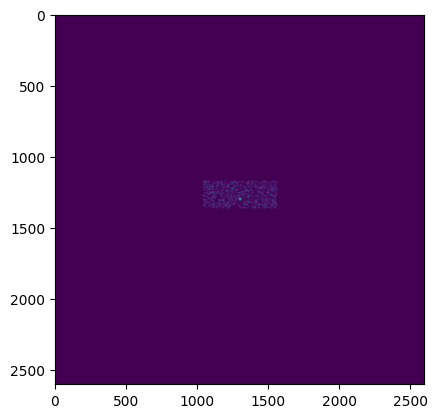

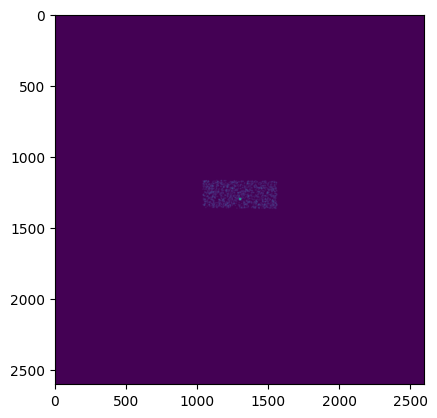

In [11]:
test = create_all_points(focus_1_05[-1][-1])*13
print(len(focus_1_05[-1]))
from src.SMT_Analysis_BP.helpers.simulate_foci import get_gaussian
mapped_array = np.zeros((200*13,200*13))
for i in range(len(test)):
    mapped_array+=get_gaussian(test[i], np.ones(2)*30./(10.), [np.arange(0,200*13,1.), np.arange(0,200*13,1.)])
plt.imshow(mapped_array)
plt.show()

#do it with the scale space plus module
testing = SM_reconstruction_image((200,200))
testing_mapped = testing.make_reconstruction(test/13.,30)
plt.imshow(testing_mapped)
plt.show()

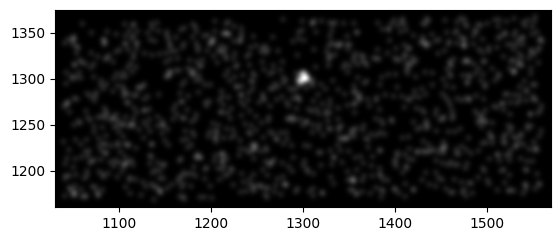

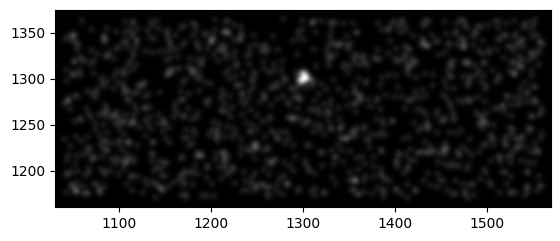

In [12]:
cell_space = np.array([80,120,90,105])
plt.imshow(testing_mapped,cmap="gray")
plt.ylim(90*13 -10,105*13 +10)
plt.xlim(80*13 -10,120*13 +10)
plt.show()

plt.imshow(mapped_array,cmap="gray")
plt.ylim(90*13 -10,105*13 +10)
plt.xlim(80*13 -10,120*13 +10)
plt.show()

In [ ]:
from src.SMT_Analysis_BP.helpers.blob_detection import blob_detection
def scale_utility(img_map,threshold):
    b = blob_detection(path = img_map,\
                    median= False,\
                    threshold= threshold, \
                    min_sigma= 1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 30, \
                    overlap = 0.5, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":5,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    return c
a = scale_utility(testing_mapped.T,5e-2)

In [ ]:
print(a)

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
ax.imshow(mapped_array,cmap = 'gray')
ax.set_ylim(400,600)
ax.set_xlim(400,600)
cir = plt.Circle((500,500),2.51,color = 'r',fill = False)
ax.add_artist(cir)



In [ ]:
plt.imshow(focus_1_05[-2][-1][-1][-1][-1],cmap='gray')
plt.ylim(340/4.,500/4.)
plt.xlim(300/4.,500/4.)

In [13]:
#recouple the parameters
focus_1_track_lengths, focus_1_repeats, focus_1_D_DBSCAN,focus_1_minPts_DBSCAN,focus_1_density_dif,focus_1_threshold_changes = focus_1_params


In [ ]:
print(focus_1_track_lengths)
print(focus_1_density_dif)

In [ ]:
print(len(focus_1_05[-1]))
print(len(focus_1_track_lengths))
print(len(focus_1_density_dif))
print(focus_1_repeats)
print(focus_1_threshold_changes)
#the index for the ordering of focus_1_05[-1] is containing the flattened list over track_lengths,density_dif, and repeats.
#so a*i + b*j + c*k = m is the index equations
#a=45,b=3,c=1


In [ ]:
ID_same_size_05_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([0.5]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 3
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([8.5e2,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict


In [5]:
#define function to perfrom scale-space+
def scale_space_plus_util(initial_dict_used,track_lengths,density_dif,repeats,threshold_changes,true_center,true_scale,loc_error=26,grid_scale=5,image_X=200,image_Y=200,originial_pixel_size=130,cell_img=np.array([80,120,90,105])):
    #TP for the scale selection
    TP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    FP_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats))
    center_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(true_center)))
    scale_error_collection_scale = np.zeros((len(track_lengths),len(density_dif),len(threshold_changes),repeats,len(true_scale)))
    
    ID_sim = {"initial_centers":true_center*grid_scale,
              "initial_scale":true_scale*grid_scale}
    loc_error_pix_scaled = loc_error/(originial_pixel_size/grid_scale)
    for i in range(len(track_lengths)):
        for j in range(len(density_dif)):
            for k in range(repeats):
                #okay lets make the initial dict
                ID_sim_old, cell_parms_sim, global_sim_params_sim = utility_params(initial_dict_used,track_lengths[i],1,density_dif[j],"constant",1.)
                #lets simulate the data
                cell_sim = simulate_cells.Simulate_cells(cell_parms_sim,global_sim_params_sim)
                a_sim = cell_sim.get_cell()
                
                points_per_frame_dict = create_all_points(a_sim["points_per_frame"])*grid_scale
                mapped_array = np.zeros((image_X*grid_scale,image_Y*grid_scale))
                for t in range(len(points_per_frame_dict)):
                    mapped_array+=get_gaussian(points_per_frame_dict[t], np.ones(2)*loc_error_pix_scaled, [np.arange(0,image_X*grid_scale,1.), np.arange(0,image_Y*grid_scale,1.)])

                #lets perform scale selection on the simulated data
                for l in range(len(threshold_changes)):
                    c_sim_LD = scale_utility(img_map = mapped_array,threshold = threshold_changes[l])
                    #lets get the true positives and errors
                    true_positive_num,false_positives,true_center_TP_center_error,true_center_TP_scale_error = true_positive_and_erros(ID_sim,c_sim_LD,center_threshold=1)
                    #lets update the collection
                    TP_collection_scale[i,j,l,k] = true_positive_num
                    FP_collection_scale[i,j,l,k] = false_positives
                    center_error_collection_scale[i,j,l,k,:] = true_center_TP_center_error
                    scale_error_collection_scale[i,j,l,k,:] = true_center_TP_scale_error
                #print updates
                print("Completed: ",i+1,"/",len(track_lengths)," ",j+1,"/",len(density_dif)," ",k+1,"/",repeats)
    scale_collection = [TP_collection_scale,FP_collection_scale,center_error_collection_scale,scale_error_collection_scale]
    return scale_collection
     

In [ ]:
ID_same_size_2_1 = {
    "initial_centers":np.array([[100,100]]),
    "initial_scale": np.array([2]),
    "diffusion_coefficient": np.array([0]),
    "hurst_exponent": np.array([0.2])  
}
#lets set up a range of lengths of tracks to simulate
track_lengths = np.array([100,200,300,400,500,600,700,800,900,1000,1100,1200])#focus_1_track_lengths#np.array([100])#,200,300,400,500,600,700,800,900,1000,1100,1200])
repeats = 2
D_DBSCAN = 0.6
minPts_DBSCAN = 5
density_dif = np.array([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15])#focus_1_density_dif#np.array([10])#,2,3,4,5,6,7,8,9,10,11,12,13,14,15])
threshold_changes = np.array([1e-2])#,9.5e2,1e3])
#we are going to use ID_same_size_1_1 as the initial dict
testing = scale_space_plus_util(ID_same_size_2_1,track_lengths,density_dif,repeats,threshold_changes,np.array([[100,100]]),np.array([2]),loc_error=26,grid_scale=5,image_X=200,image_Y=200)

In [ ]:
SAVE = True
if SAVE == True:
    Param_file = [track_lengths,repeats,D_DBSCAN,minPts_DBSCAN,density_dif,threshold_changes]
    with open('/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/SCALE_PLUS_testing.pkl', 'wb') as f:
        pickle.dump(testing, f)
    with open('/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2pix/Param_file_testing.pkl', 'wb') as f:
        pickle.dump(Param_file, f)

In [18]:
testing = 0
import pickle
with open('/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_0.5pix/SCALE_PLUS_testing.pkl', 'rb') as f:
    testing = pickle.load(f)

540


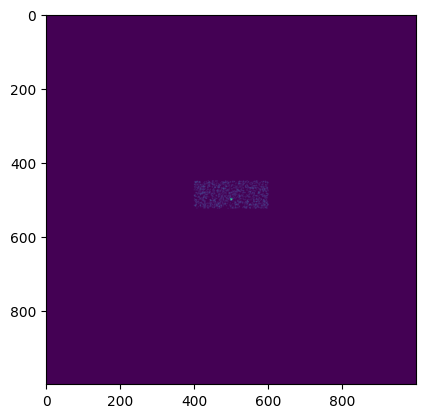

(75.0, 125.0)

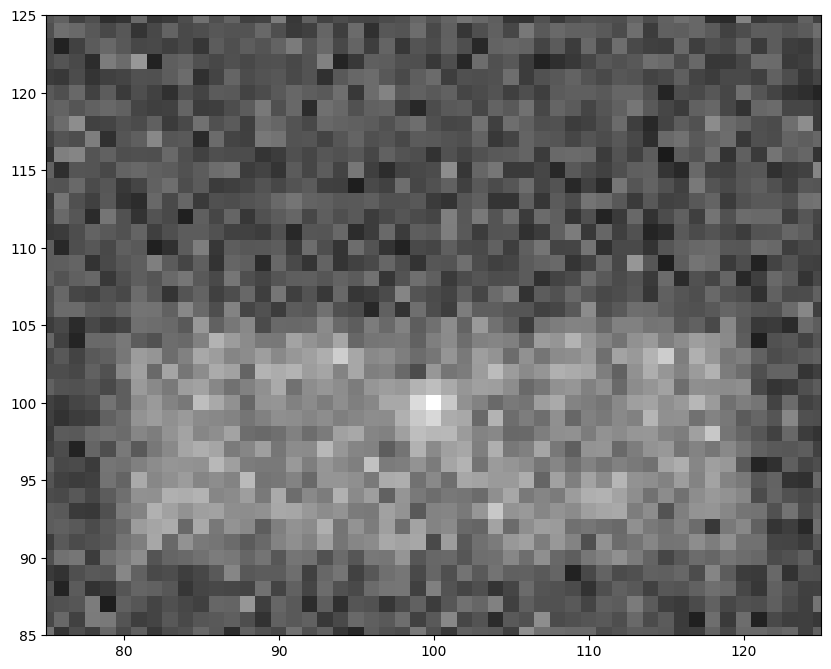

In [17]:
test = create_all_points(focus_1_05[-1][-1])*5
print(len(focus_1_05[-1]))
from src.SMT_Analysis_BP.helpers.simulate_foci import get_gaussian
mapped_array = np.zeros((200*5,200*5))
for i in range(len(test)):
    mapped_array+=get_gaussian(test[i], np.ones(2)*1, [np.arange(0,200*5,1.), np.arange(0,200*5,1.)])
plt.imshow(mapped_array)
plt.show()
from src.SMT_Analysis_BP.helpers.blob_detection import blob_detection
def scale_utility(img_map,threshold):
    b = blob_detection(path = img_map,\
                    median= False,\
                    threshold= threshold, \
                    min_sigma= 1/np.sqrt(2), \
                    max_sigma = 10/np.sqrt(2), \
                    num_sigma= 500, \
                    overlap = 0.5, \
                    logscale=False,
                    verbose=True)
    b._update_fitting_parameters(kwargs={"mask_size":5,
                                "plot_fit":False,
                                "fitting_image":"Original",
                                "radius_func":None,
                                "sigma_range":2,
                                "centroid_range":2})
    c = b.detection(type = "bp")
    return c
a = scale_utility(mapped_array,5e-2)
fig,ax = plt.subplots(figsize = (10,10))
ax.imshow(mapped_array,cmap = 'gray')
ax.set_ylim(400,600)
ax.set_xlim(400,600)
cir = plt.Circle((500,500),2.51,color = 'r',fill = False)
ax.add_artist(cir)

plt.imshow(focus_1_05[-2][-1][-1][-1][-1],cmap='gray')
plt.ylim(340/4.,500/4.)
plt.xlim(300/4.,500/4.)

#

In [ ]:
num_points = len(test)
#get num_points randomly distributed across the cell space
cell_space = np.array([80,120,90,105])
x_normal = np.random.uniform(cell_space[0],cell_space[1],num_points)
y_normal = np.random.uniform(cell_space[2],cell_space[3],num_points)
#store it in a array with [[x,y],[x,y]...]
points_normal = np.array([x_normal,y_normal]).T
points_scaled = points_normal*5
#rescale to the cell space *5
cell_space_scaled = cell_space*5

mapped_array_normal = np.zeros((200,200))
mapped_array_scaled = np.zeros((200*5,200*5))

for i in range(len(points_normal)):
    mapped_array_normal+=get_gaussian(points_normal[i], np.ones(2)*1, [np.arange(0,200,1.), np.arange(0,200,1.)])
    mapped_array_scaled+=get_gaussian(points_scaled[i], np.ones(2)*1, [np.arange(0,200*5,1.), np.arange(0,200*5,1.)])






In [ ]:
thresholds = np.logspace(-2,0,15)
#perform scale_utility on the mapped array for each threshold
scaled_utility = [len(scale_utility(mapped_array_scaled,threshold)["Fitted"]) for threshold in thresholds]
print(scaled_utility)



In [ ]:
boundary_pixels = 2
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[1, 0])
ax2 = fig.add_subplot(gs[1, 1])
ax1.plot(thresholds,scaled_utility, color='blue',marker='o')
ax1.set_xscale('log')
ax1.set_yscale('log')
ax1.set_xlabel('Threshold')
ax1.set_ylabel('False Positives', color='blue')
ax1.set_title('False Positives for Uniformly Distributed Points')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.plot(thresholds,np.array(scaled_utility_original)-1, color='blue',marker='o')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax2.set_xlabel('Threshold')
#ax2.set_ylabel('False Positives', color='blue')
ax2.set_title('False and True Positive Rate for Clustered Points')

#let the ax1 and ax2 share the same y-axis
ax1.get_shared_y_axes().join(ax1, ax2)
ax1.set_ylim([1e-1,1e3])
ax2.set_ylim([1e-1,1e3])
#make a twin axis for the second plot
ax3 = ax2.twinx()
ax3.plot(thresholds, 100.*(np.array(scaled_utility_original)>0), color='red',marker='o')
ax3.set_ylabel('True Positive Rate (%)', color='red')
ax3.tick_params(axis='y', labelcolor='red')
ax2.tick_params(axis='y', labelcolor='blue')
ax3.set_yticks([0,100])


#lets plot the image of the two cells one uniform and the other the original

ax4 = fig.add_subplot(gs[0, 0])
ax5 = fig.add_subplot(gs[0, 1])

img4 = ax4.imshow(mapped_array_scaled, cmap='gray')
ax4.set_title('Uniformly Distributed Points')
ax4.set_xticks([])
ax4.set_yticks([])
#restrict ax4 to the cell space +- 5 pixels
ax4.set_xlim([cell_space[0]*5-boundary_pixels*5,cell_space[1]*5+boundary_pixels*5])
ax4.set_ylim([cell_space[2]*5-boundary_pixels*5,cell_space[3]*5+boundary_pixels*5])

#add the rectangle for the cell boundaries
rect = plt.Rectangle((cell_space[0]*5,cell_space[2]*5),cell_space[1]*5-cell_space[0]*5,cell_space[3]*5-cell_space[2]*5, color='w', fill=False,linestyle='--',linewidth=2)
ax4.add_patch(rect)

img5 = ax5.imshow(mapped_array, cmap='gray')
ax5.set_title('Clustered Points')
ax5.set_xticks([])
ax5.set_yticks([])
#restrict ax5 to the cell space +- 5 pixels
ax5.set_xlim([cell_space[0]*5-boundary_pixels*5,cell_space[1]*5+boundary_pixels*5])
ax5.set_ylim([cell_space[2]*5-boundary_pixels*5,cell_space[3]*5+boundary_pixels*5])
#add the rectangle for the cell boundaries
rect = plt.Rectangle((cell_space[0]*5,cell_space[2]*5),cell_space[1]*5-cell_space[0]*5,cell_space[3]*5-cell_space[2]*5, color='w', fill=False,linestyle='--',linewidth=2)
ax5.add_patch(rect)

#put a colorbar for each of the ax4 and ax5
cbar4 = fig.colorbar(img4,shrink=0.5)
cbar5 = fig.colorbar(img5,shrink=0.5)
cbar4.set_label('Intensity')
cbar5.set_label('Intensity')


plt.tight_layout()


SAVE = False
if SAVE == True:
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/threshold_solver.svg',format='svg',dpi=200)
plt.show()

<Figure size 640x480 with 0 Axes>

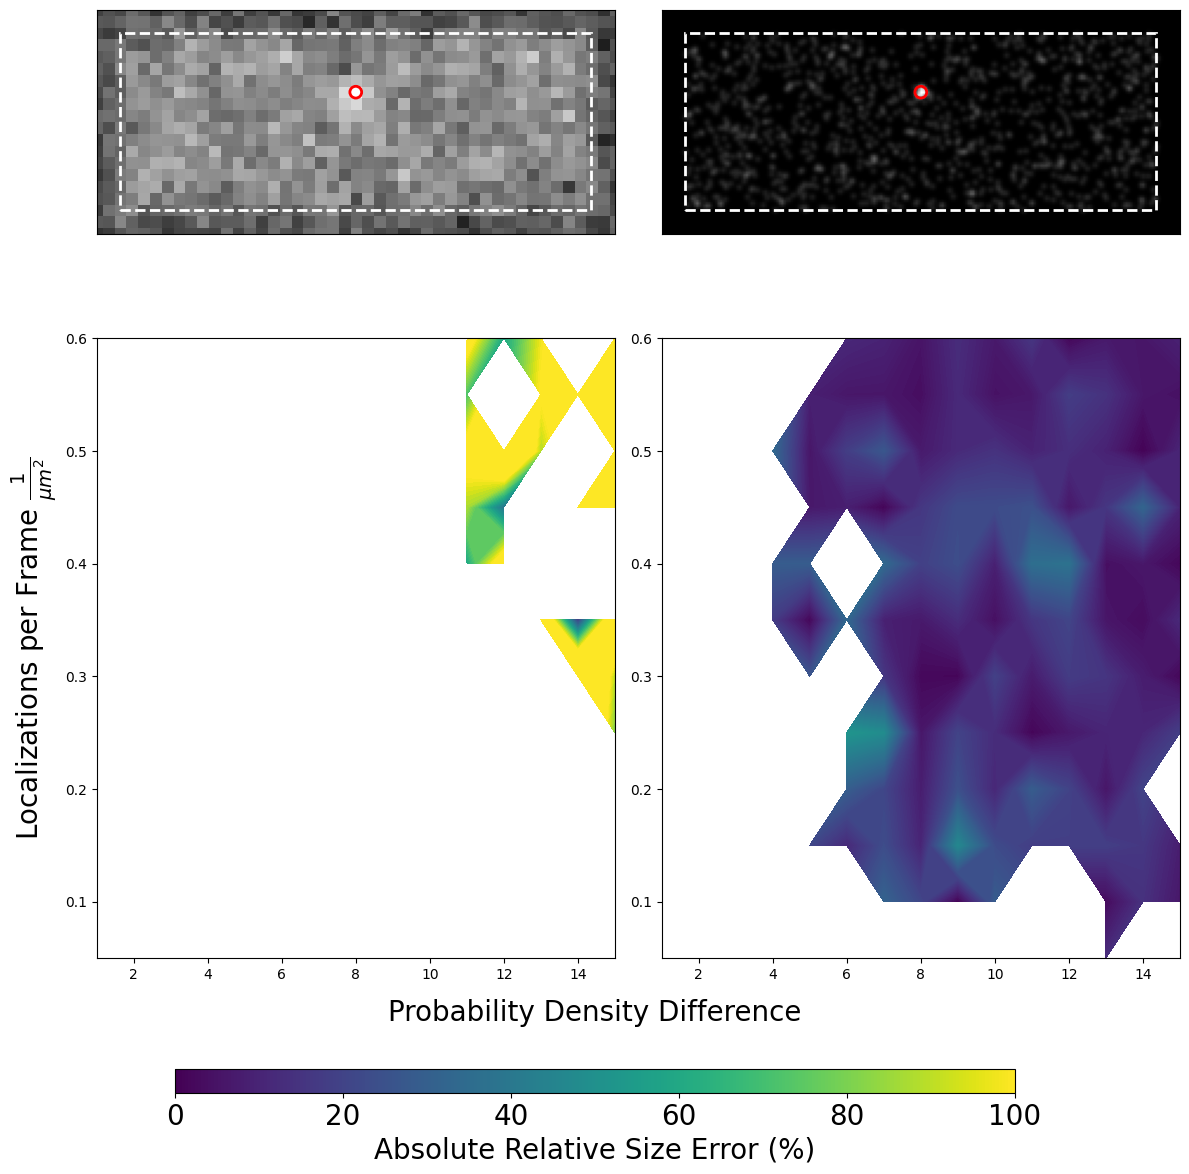

In [31]:
plt.clf()
fig = plt.figure(figsize=(12,12))
gs = fig.add_gridspec(2, 2)
import matplotlib as mpl


ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])

ax2.imshow(mapped_array,cmap = "gray")
ax1.imshow(focus_1_05[-2][-1][-1][-1][-1],cmap='gray')

cell_space = np.array([80,120,90,105])
center_05 = np.array([100,100])
scale_05 = 0.5

#restrict ax1 to the cell space +- 5 pixels
boundary_pixels = 2
ax1.set_xlim([cell_space[0]-boundary_pixels,cell_space[1]+boundary_pixels])
ax1.set_ylim([cell_space[2]-boundary_pixels,cell_space[3]+boundary_pixels])

#restrict ax2 to the cell space +- 5 pixels
ax2.set_xlim([cell_space[0]*5-boundary_pixels*5,cell_space[1]*5+boundary_pixels*5])
ax2.set_ylim([cell_space[2]*5-boundary_pixels*5,cell_space[3]*5+boundary_pixels*5])

#make a rectangle for the cell space
rect = plt.Rectangle((cell_space[0],cell_space[2]),cell_space[1]-cell_space[0],cell_space[3]-cell_space[2], color='w', fill=False,linestyle='--',linewidth=2)
ax1.add_patch(rect)
rect = plt.Rectangle((cell_space[0]*5,cell_space[2]*5),cell_space[1]*5-cell_space[0]*5,cell_space[3]*5-cell_space[2]*5, color='w', fill=False,linestyle='--',linewidth=2)
ax2.add_patch(rect)

#draw a circle for the center of the focus 
circle = plt.Circle((center_05[0],center_05[1]), scale_05, color='r', fill=False,linestyle='-',linewidth=2)
ax1.add_patch(circle)
circle = plt.Circle((center_05[0]*5,center_05[1]*5), scale_05*5, color='r', fill=False,linestyle='-',linewidth=2)
ax2.add_patch(circle)

#remove the ticks
ax1.set_xticks([])
ax1.set_yticks([])
ax2.set_xticks([])
ax2.set_yticks([])


# #on the next two pots plot the point density as a contour plot

# normal_points = create_all_points(focus_1_05[-1][-1])
# scaled_points = create_all_points(focus_1_05[-1][-1])*5

# #make bins from the cell space +- 5 pixels for x and y
# x_bins_normal = np.linspace(cell_space[0]-boundary_pixels,cell_space[1]+boundary_pixels,cell_space[1]-cell_space[0]+2*boundary_pixels)
# y_bins_normal = np.linspace(cell_space[2]-boundary_pixels,cell_space[3]+boundary_pixels,cell_space[3]-cell_space[2]+2*boundary_pixels)

# #make bins from the cell space +- 5 pixels for x and y for the scaled
# x_bins_scaled = np.linspace(cell_space[0]*5-boundary_pixels*5,cell_space[1]*5+boundary_pixels*5,cell_space[1]*5-cell_space[0]*5+2*boundary_pixels*5)
# y_bins_scaled = np.linspace(cell_space[2]*5-boundary_pixels*5,cell_space[3]*5+boundary_pixels*5,cell_space[3]*5-cell_space[2]*5+2*boundary_pixels*5)

# #make a histogram of the points in   2D grid
# H, xedges, yedges = np.histogram2d(normal_points[:,0], normal_points[:,1], bins=[x_bins_normal,y_bins_normal])
# #make a contour plot of the histogram
# ax3.contourf(xedges[:-1], yedges[:-1], H.T, 100, cmap='gray')
# #make a histogram of the points in   2D grid
# H, xedges, yedges = np.histogram2d(scaled_points[:,0], scaled_points[:,1], bins=[x_bins_scaled,y_bins_scaled])
# #make a contour plot of the histogram
# ax4.contourf(xedges[:-1], yedges[:-1], H.T, 100, cmap='gray')

# # #plot the points as a scatter plot
# # ax3.scatter(normal_points[:,0],normal_points[:,1],s=0.1,c='k')
# # ax4.scatter(scaled_points[:,0],scaled_points[:,1],s=0.1,c='k')

# # #set the x and y limits for the contour plots
# # ax3.set_xlim([cell_space[0]-boundary_pixels,cell_space[1]+boundary_pixels])
# # ax3.set_ylim([cell_space[2]-boundary_pixels,cell_space[3]+boundary_pixels])
# # ax4.set_xlim([cell_space[0]*5-boundary_pixels*5,cell_space[1]*5+boundary_pixels*5])
# # ax4.set_ylim([cell_space[2]*5-boundary_pixels*5,cell_space[3]*5+boundary_pixels*5])












X, Y = np.meshgrid(focus_1_density_dif, focus_1_track_lengths/4/500.)

#we also need to find the min and max values for both the scale-space and DBSCAN errors
#we will use these to set the colorbar limits


#set to 1 to see a clearer picture of the scale-space errors
min_val_2 = 0
max_val_2 = 100
min_val = 0
max_val = 100

#for 0.5 size
ax5 = fig.add_subplot(gs[1, 0])
#plot the scale error for the 0.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_1_05[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax5.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 0.5 for scale-space
ax6 = fig.add_subplot(gs[1, 1])
Z = np.nanmean(np.nanmean(np.nanmean(testing[3],axis=2),axis=2),axis=2)*100
#contour plot
ax6.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)


#lets make a single colorbar for all the plots that is at the bottom and horizontal
cbar_ax = fig.add_axes([0.15, -0.08, 0.7, 0.02])
#make a colorbar with vmin and vmax set
#make a mappable object that can be used to make the colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array([])
mappable.set_clim(min_val, max_val)
#make the colorbar
fig.colorbar(mappable, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xlabel('Absolute Relative Size Error (%)',fontsize=20)
#make the ticks on the colorbar fontsize 20
cbar_ax.tick_params(labelsize=20)


#make a label for the X axis as "Probability Density Difference"
# this needs to be shared by the bottom row
fig.text(0.5, -0.02, 'Probability Density Difference', ha='center',fontsize=20)
#make a label for the Y axis as "Localizations per Frame 1/um^2" in latex
# this needs to be shared by the left column
#fig.text(-0.01, 0.2, r'Localizations per Frame $\frac{1}{\mu m^2}$', va='center', rotation='vertical',fontsize=20)
ax5.set_ylabel(r'Localizations per Frame $\frac{1}{\mu m^2}$',fontsize=20)

plt.tight_layout()

SAVE = False
if SAVE == True:
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/0.5_Scale_PLUS_L_D_scan.svg',format='svg',dpi=1200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/0.5_Scale_PLUS_scan.png',format='png',dpi=200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/0.5_Scale_PLUS_scan.eps',format='eps',dpi=200)
plt.show()


In [ ]:
print(testing)

In [ ]:
#lets plot the 3D plot of the TP for each track length and density dif by averaging over the repeats
#plot the center and scale error too
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0],projection='3d')
ax3 = fig.add_subplot(gs[0, 1],projection='3d')

#lets plot the TP
X, Y = np.meshgrid(focus_1_density_dif, focus_1_track_lengths/4/500.)
Z = np.mean(focus_1_2[0][1],axis=2)
surf = ax1.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax1.set_xlabel("Probability Density Difference",fontsize=20)
ax1.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax1.set_zlabel("True Positive Rate",fontsize=20)
ax1.set_title("True Positive Rate",fontsize=20)


#lets plot the scale error
X, Y = np.meshgrid(focus_1_density_dif, focus_1_track_lengths/4/500.)
Z = np.nanmean(np.nanmean(focus_1_2[0][3],axis=2),axis=2)
surf = ax3.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax3.set_xlabel("Probability Density Difference",fontsize=20)
ax3.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax3.set_zlabel("Percent Size Error",fontsize=20)
ax3.set_title("Percent Size Error",fontsize=20)
ax3.set_zlim(0,1)

plt.show()

#repeat for the scale selection
fig = plt.figure(figsize=(20,10))
gs = fig.add_gridspec(1, 2)
ax1 = fig.add_subplot(gs[0, 0],projection='3d')
ax3 = fig.add_subplot(gs[0, 1],projection='3d')

#lets plot the TP
X, Y = np.meshgrid(focus_1_density_dif, focus_1_track_lengths/4/500.)
Z = np.mean(focus_1_2[1][1][:,:,0,:],axis=2)
surf = ax1.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax1.set_xlabel("Probability Density Difference",fontsize=20)
ax1.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax1.set_zlabel("True Positive Rate",fontsize=20)
ax1.set_title("True Positive Rate",fontsize=20)


#lets plot the scale error
X, Y = np.meshgrid(focus_1_density_dif, focus_1_track_lengths/4/500.)
Z = np.nanmean(np.nanmean(focus_1_2[1][3][:,:,0,:],axis=2),axis=2)
surf = ax3.plot_surface(X, Y, Z,linewidth=0, antialiased=False,cmap="viridis")
ax3.set_xlabel("Probability Density Difference",fontsize=20)
ax3.set_ylabel("Localization Density per Frame" + r" $\frac{1}{\mu m_{2}}$",fontsize=20)
ax3.set_zlabel("Percent Size Error",fontsize=20)
ax3.set_title("Percent Size Error",fontsize=20)
ax3.set_zlim(0,1)

plt.show()


In [ ]:
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(6, 2)
import matplotlib as mpl

X, Y = np.meshgrid(focus_1_density_dif, focus_1_track_lengths/4/500.)

#we also need to find the min and max values for both the scale-space and DBSCAN errors
#we will use these to set the colorbar limits

#first we will find the min and max values for the scale-space errors
#DBSCAN min/max
min_val = np.nanmin([np.nanmin(np.nanmin(focus_1_05[0][3],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_1[0][3],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_15[0][3],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_2[0][3],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_25[0][3],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_3[0][3],axis=2),axis=2)])
                    
max_val = np.nanmax([np.nanmax(np.nanmax(focus_1_05[0][3],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_1[0][3],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_15[0][3],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_2[0][3],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_25[0][3],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_3[0][3],axis=2),axis=2)])

#scale-space min/max
min_val_2 = np.nanmin([np.nanmin(np.nanmin(focus_1_05[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_1[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_15[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_2[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_25[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmin(np.nanmin(focus_1_3[1][3][:,:,0,:],axis=2),axis=2)])

max_val_2 = np.nanmax([np.nanmax(np.nanmax(focus_1_05[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_1[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_15[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_2[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_25[1][3][:,:,0,:],axis=2),axis=2),
                    np.nanmax(np.nanmax(focus_1_3[1][3][:,:,0,:],axis=2),axis=2)])

print(min_val,max_val,min_val_2,max_val_2)

#set to 1 to see a clearer picture of the scale-space errors
min_val_2 = 0
max_val_2 = 100
min_val = 0
max_val = 100

#for 0.5 size
ax1 = fig.add_subplot(gs[0, 0])
#plot the scale error for the 0.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_1_05[0][3],axis=2),axis=2)*100
#contour plot
ax1.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 0.5 for scale-space
ax2 = fig.add_subplot(gs[0, 1])
Z = np.nanmean(np.nanmean(focus_1_05[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax2.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)


#for 1.0 size
ax3 = fig.add_subplot(gs[1, 0])
#plot the scale error for the 1.0 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_1_1[0][3],axis=2),axis=2)*100
#contour plot
ax3.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 1.0 for scale-space
ax4 = fig.add_subplot(gs[1, 1])
Z = np.nanmean(np.nanmean(focus_1_1[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax4.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)

#for 1.5 size
ax5 = fig.add_subplot(gs[2, 0])
#plot the scale error for the 1.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_1_15[0][3],axis=2),axis=2)*100
#contour plot
ax5.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 1.5 for scale-space
ax6 = fig.add_subplot(gs[2, 1])
Z = np.nanmean(np.nanmean(focus_1_15[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax6.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)

#for 2.0 size
ax7 = fig.add_subplot(gs[3, 0])
#plot the scale error for the 2.0 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_1_2[0][3],axis=2),axis=2)*100
#contour plot
ax7.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.0 for scale-space
ax8 = fig.add_subplot(gs[3, 1])
Z = np.nanmean(np.nanmean(focus_1_2[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax8.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)

#for 2.5 size
ax9 = fig.add_subplot(gs[4, 0])
#plot the scale error for the 2.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_1_25[0][3],axis=2),axis=2)*100
#contour plot
ax9.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.5 for scale-space
ax10 = fig.add_subplot(gs[4, 1])
Z = np.nanmean(np.nanmean(focus_1_25[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax10.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)

#for 3.0 size
ax11 = fig.add_subplot(gs[5, 0])
#plot the scale error for the 3.0 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_1_3[0][3],axis=2),axis=2)*100
#contour plot
ax11.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 3.0 for scale-space
ax12 = fig.add_subplot(gs[5, 1])
Z = np.nanmean(np.nanmean(focus_1_3[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax12.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)

#remove the x ticks from all the rows except the bottom one
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10]:
    plt.setp(ax.get_xticklabels(), visible=False)
    ax.set_xlabel('')
#remove the y ticks from all the columns except the left one
for ax in [ax2,ax4,ax6,ax8,ax10,ax12]:
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.set_ylabel('')

#set the fontsize for the ticks on the axis to be 20
for ax in [ax1,ax2,ax3,ax4,ax5,ax6,ax7,ax8,ax9,ax10,ax11,ax12]:
    ax.tick_params(axis='both', which='major', labelsize=20)


#lets make a single colorbar for all the plots that is at the bottom and horizontal
cbar_ax = fig.add_axes([0.15, -0.08, 0.7, 0.02])
#make a colorbar with vmin and vmax set
#make a mappable object that can be used to make the colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array([])
mappable.set_clim(min_val, max_val)
#make the colorbar
fig.colorbar(mappable, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xlabel('Absolute Relative Size Error (%)',fontsize=20)
#make the ticks on the colorbar fontsize 20
cbar_ax.tick_params(labelsize=20)


#make a label for the X axis as "Probability Density Difference"
# this needs to be shared by the bottom row
fig.text(0.5, -0.02, 'Probability Density Difference', ha='center',fontsize=20)
#make a label for the Y axis as "Localizations per Frame 1/um^2" in latex
# this needs to be shared by the left column
fig.text(-0.01, 0.5, r'Localizations per Frame $\frac{1}{\mu m^2}$', va='center', rotation='vertical',fontsize=20)

#on the far left column, add a label for the size of the clusters for each row
fig.text(-0.025, 0.90, r'$65nm$', va='center', rotation='vertical',fontsize=20)
fig.text(-0.025, 0.75, r'$130nm$', va='center', rotation='vertical',fontsize=20)
fig.text(-0.025, 0.60, r'$195nm$', va='center', rotation='vertical',fontsize=20)
fig.text(-0.025, 0.45, r'$260nm$', va='center', rotation='vertical',fontsize=20)
fig.text(-0.025, 0.30, r'$325nm$', va='center', rotation='vertical',fontsize=20)
fig.text(-0.025, 0.15, r'$390nm$', va='center', rotation='vertical',fontsize=20)

#on the top row, add a label for DBSCAN and Scale-Space
fig.text(0.25, 1.00, r'DBSCAN', va='center', rotation='horizontal',fontsize=20)
fig.text(0.75, 1.00, r'Scale-Space', va='center', rotation='horizontal',fontsize=20)


plt.tight_layout()

SAVE = False
if SAVE == True:
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan.svg',format='svg',dpi=1200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan.png',format='png',dpi=200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan.eps',format='eps',dpi=200)
plt.show()

In [ ]:
#lets load the 2-4 condensate data for size 2.5

with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_1_25 = pickle.load(f)
with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/2_clusters/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_2_25 = pickle.load(f)
with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/3_clusters/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_3_25 = pickle.load(f)
with open("/Volumes/Baljyot_HD/PHD_Thesis_Figures/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Size_2.5pix/4_clusters/DBSCAN_scale_file_data.pkl",'rb') as f:
    focus_4_25 = pickle.load(f)



In [ ]:
#make a figure with 4 panels
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(2, 4)

#set to 1 to see a clearer picture of the scale-space errors
min_val_2 = 0
max_val_2 = 100
min_val = 0
max_val = 100

X, Y = np.meshgrid(focus_1_density_dif, focus_1_track_lengths/4/500.)

#add the panels
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

#plot the scale error for the 2.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_1_25[0][3],axis=2),axis=2)*100
#contour plot
ax1.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.5 for scale-space
Z = np.nanmean(np.nanmean(focus_1_25[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax2.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)


#for 2 clusters
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])

#plot the scale error for the 2.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_2_25[0][3],axis=2),axis=2)*100
#contour plot
ax3.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.5 for scale-space
Z = np.nanmean(np.nanmean(focus_2_25[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax4.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)


#for 3 clusters
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

#plot the scale error for the 2.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_3_25[0][3],axis=2),axis=2)*100
#contour plot
ax5.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.5 for scale-space
Z = np.nanmean(np.nanmean(focus_3_25[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax6.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)


#for 4 clusters
ax7 = fig.add_subplot(gs[0, 3])
ax8 = fig.add_subplot(gs[1, 3])

#plot the scale error for the 2.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_4_25[0][3],axis=2),axis=2)*100
#contour plot
ax7.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.5 for scale-space
Z = np.nanmean(np.nanmean(focus_4_25[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax8.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)

#remove the x ticks from the plots other than the bottom row
ax1.set_xticks([])
ax3.set_xticks([])
ax5.set_xticks([])
ax7.set_xticks([])

#remove the y ticks from the plots other than the left column
ax3.set_yticks([])
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])
ax7.set_yticks([])
ax8.set_yticks([])

#set the axis ticks to font size 20
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax5.tick_params(axis='both', which='major', labelsize=20)
ax6.tick_params(axis='both', which='major', labelsize=20)
ax7.tick_params(axis='both', which='major', labelsize=20)
ax8.tick_params(axis='both', which='major', labelsize=20)

fig.text(0.5, -0.02, 'Probability Density Difference', ha='center',fontsize=20)
fig.text(-0.01, 0.5, r'Localizations per Frame $\frac{1}{\mu m^2}$', va='center', rotation='vertical',fontsize=20)

fig.text(-0.01, 0.7, r'DBSCAN', va='center', rotation='vertical',fontsize=20)
fig.text(-0.01, 0.3, r'Scale-Space', va='center', rotation='vertical',fontsize=20)

#make a title for each column indicating the number of clusters
fig.text(0.125, 1.005, r'1 Cluster', va='center', rotation='horizontal',fontsize=20)
fig.text(0.375, 1.005, r'2 Clusters', va='center', rotation='horizontal',fontsize=20)
fig.text(0.625, 1.005, r'3 Clusters', va='center', rotation='horizontal',fontsize=20)
fig.text(0.875, 1.005, r'4 Clusters', va='center', rotation='horizontal',fontsize=20)

#lets make a single colorbar for all the plots that is at the bottom and horizontal
cbar_ax = fig.add_axes([0.15, -0.08, 0.7, 0.02])
#make a colorbar with vmin and vmax set
#make a mappable object that can be used to make the colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array([])
mappable.set_clim(min_val, max_val)
#make the colorbar
fig.colorbar(mappable, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xlabel('Absolute Relative Size Error (%)',fontsize=20)
#make the ticks on the colorbar fontsize 20
cbar_ax.tick_params(labelsize=20)

plt.tight_layout()

SAVE = False
if SAVE == True:
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan_clusters.svg',format='svg',dpi=1200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan_clusters.png',format='png',dpi=200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan_clusters.eps',format='eps',dpi=200)
plt.show()

In [ ]:


#make a figure with 4 panels
fig = plt.figure(figsize=(20,20))
gs = fig.add_gridspec(2, 4)

#set to 1 to see a clearer picture of the scale-space errors
min_val_2 = 0
max_val_2 = 100
min_val = 0
max_val = 100
focus_1_density_dif = focus_1_params[-2]
focus_1_track_lengths = focus_1_params[0]
X, Y = np.meshgrid(focus_1_density_dif, focus_1_track_lengths/4/500.)

#add the panels
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])

#plot the scale error for the 2.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_1_25[0][0],axis=2),axis=2)*100
#contour plot
ax1.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.5 for scale-space
Z = np.nanmean(np.nanmean(focus_1_25[1][0][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax2.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)


#for 2 clusters
ax3 = fig.add_subplot(gs[0, 1])
ax4 = fig.add_subplot(gs[1, 1])

#plot the scale error for the 2.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_2_25[0][0],axis=2),axis=2)*100
#contour plot
ax3.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.5 for scale-space
Z = np.nanmean(np.nanmean(focus_2_25[1][0][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax4.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)


#for 3 clusters
ax5 = fig.add_subplot(gs[0, 2])
ax6 = fig.add_subplot(gs[1, 2])

#plot the scale error for the 2.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_3_25[0][0],axis=2),axis=2)*100
#contour plot
ax5.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.5 for scale-space
Z = np.nanmean(np.nanmean(focus_3_25[1][0][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax6.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)


#for 4 clusters
ax7 = fig.add_subplot(gs[0, 3])
ax8 = fig.add_subplot(gs[1, 3])

#plot the scale error for the 2.5 size for DBSCAN
Z = np.nanmean(np.nanmean(focus_4_25[0][0],axis=2),axis=2)*100
#contour plot
ax7.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#plot the scale error for 2.5 for scale-space
Z = np.nanmean(np.nanmean(focus_4_25[1][0][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax8.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val_2,vmax=max_val_2)

#remove the x ticks from the plots other than the bottom row
ax1.set_xticks([])
ax3.set_xticks([])
ax5.set_xticks([])
ax7.set_xticks([])

#remove the y ticks from the plots other than the left column
ax3.set_yticks([])
ax4.set_yticks([])
ax5.set_yticks([])
ax6.set_yticks([])
ax7.set_yticks([])
ax8.set_yticks([])

#set the axis ticks to font size 20
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)
ax4.tick_params(axis='both', which='major', labelsize=20)
ax5.tick_params(axis='both', which='major', labelsize=20)
ax6.tick_params(axis='both', which='major', labelsize=20)
ax7.tick_params(axis='both', which='major', labelsize=20)
ax8.tick_params(axis='both', which='major', labelsize=20)

fig.text(0.5, -0.02, 'Probability Density Difference', ha='center',fontsize=20)
fig.text(-0.01, 0.5, r'Localizations per Frame $\frac{1}{\mu m^2}$', va='center', rotation='vertical',fontsize=20)

fig.text(-0.01, 0.7, r'DBSCAN', va='center', rotation='vertical',fontsize=20)
fig.text(-0.01, 0.3, r'Scale-Space', va='center', rotation='vertical',fontsize=20)

#make a title for each column indicating the number of clusters
fig.text(0.125, 1.005, r'1 Cluster', va='center', rotation='horizontal',fontsize=20)
fig.text(0.375, 1.005, r'2 Clusters', va='center', rotation='horizontal',fontsize=20)
fig.text(0.625, 1.005, r'3 Clusters', va='center', rotation='horizontal',fontsize=20)
fig.text(0.875, 1.005, r'4 Clusters', va='center', rotation='horizontal',fontsize=20)

#lets make a single colorbar for all the plots that is at the bottom and horizontal
cbar_ax = fig.add_axes([0.15, -0.08, 0.7, 0.02])
#make a colorbar with vmin and vmax set
#make a mappable object that can be used to make the colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array([])
mappable.set_clim(min_val, max_val)
#make the colorbar
fig.colorbar(mappable, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xlabel('Absolute Relative Size Error (%)',fontsize=20)
#make the ticks on the colorbar fontsize 20
cbar_ax.tick_params(labelsize=20)

plt.tight_layout()

SAVE = False
if SAVE == True:
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan_clusters.svg',format='svg',dpi=1200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan_clusters.png',format='png',dpi=200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan_clusters.eps',format='eps',dpi=200)
plt.show()

In [ ]:
#lets plot the effects of changing the threshold
fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(1, 3)

ax1 = fig.add_subplot(gs[0, 0])
#plot the scale error for the 2.0 size for Scale-Space
Z = np.nanmean(np.nanmean(focus_1_2[1][3][:,:,0,:],axis=2),axis=2)*100
#contour plot
ax1.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

ax2 = fig.add_subplot(gs[0, 1])
#plot the scale error for the 2.0 size for Scale-Space
Z = np.nanmean(np.nanmean(focus_1_2[1][3][:,:,1,:],axis=2),axis=2)*100
#contour plot
ax2.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

ax3 = fig.add_subplot(gs[0, 2])
#plot the scale error for the 2.0 size for Scale-Space
Z = np.nanmean(np.nanmean(focus_1_2[1][3][:,:,2,:],axis=2),axis=2)*100
#contour plot
ax3.contourf(X, Y, Z, 100, cmap='viridis',vmin=min_val,vmax=max_val)

#remove the ticks
ax2.set_yticks([])
ax3.set_yticks([])

fig.text(0.5, -0.02, 'Probability Density Difference', ha='center',fontsize=20)
fig.text(-0.01, 0.5, r'Localizations per Frame $\frac{1}{\mu m^2}$', va='center', rotation='vertical',fontsize=20)

#on the top row label the titles as the threshold used
ax1.set_title(r'$80\%$' + r"$T$",fontsize=20)
ax2.set_title(r'$90\%$' + r"$T$",fontsize=20)
ax3.set_title(r"$T$",fontsize=20)

#lets make a single colorbar for all the plots that is at the bottom and horizontal
cbar_ax = fig.add_axes([0.15, -0.08, 0.7, 0.02])
#make a colorbar with vmin and vmax set
#make a mappable object that can be used to make the colorbar
mappable = plt.cm.ScalarMappable(cmap='viridis')
mappable.set_array([])
mappable.set_clim(min_val, max_val)
#make the colorbar
fig.colorbar(mappable, cax=cbar_ax, orientation='horizontal')
cbar_ax.set_xlabel('Absolute Relative Size Error (%)',fontsize=20)
#make the ticks on the colorbar fontsize 20
cbar_ax.tick_params(labelsize=20)
#set the axis ticks to font size 20
ax1.tick_params(axis='both', which='major', labelsize=20)
ax2.tick_params(axis='both', which='major', labelsize=20)
ax3.tick_params(axis='both', which='major', labelsize=20)

plt.tight_layout()
SAVE = False
if SAVE == True:
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan_threshold.svg',format='svg',dpi=1200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan_threshold.png',format='png',dpi=200)
    plt.savefig('/Users/baljyot/Documents/2022-2023/PhD_Thesis/Figures/Chapter_3/Figure_4/Data/Density_Points_Scan_Sizes_threshold_1e3/Same_Size_L_D_scan_threshold.eps',format='eps',dpi=200)
plt.show()